# Sentiment Analysis: Classifiers

In [1]:
# Importing Libraries
import pandas as pd
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import preprocessor as p
from nltk.stem import WordNetLemmatizer                      
from pywsd.utils import lemmatize_sentence
from sklearn import svm
import emoji    
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn import tree

Warming up PyWSD (takes ~10 secs)... took 11.123661756515503 secs.


In [2]:
# The dataset ('Tweets.csv) is imported and saved in the variable 'data'
# Only the text of the tweets is saved in the variable 'tweets'. 
# A sample is printed to verify that they have been loaded correctly.

data= pd.read_csv('./Data/Tweets.csv')
tweets = data['text']
tweets.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [3]:
# The sentiment expressed with the "neutral" token is replaced by the "positive" token. 
# We get a more equal amount of tweets labeled with positive and negative polarity.
# The result is a series of pandas stored in the variable 'target' that contains the polarity
# of each of the tweets of the main dataset ('data').

data.replace({'airline_sentiment' : 'neutral'}, 'positive', inplace=True)
target = data['airline_sentiment']
print(data['airline_sentiment'])      

0        positive
1        positive
2        positive
3        negative
4        negative
5        negative
6        positive
7        positive
8        positive
9        positive
10       positive
11       positive
12       positive
13       positive
14       positive
15       negative
16       positive
17       negative
18       positive
19       positive
20       negative
21       positive
22       positive
23       positive
24       negative
25       negative
26       negative
27       positive
28       negative
29       positive
           ...   
14610    negative
14611    positive
14612    negative
14613    negative
14614    negative
14615    negative
14616    negative
14617    positive
14618    negative
14619    positive
14620    negative
14621    negative
14622    negative
14623    positive
14624    negative
14625    positive
14626    negative
14627    negative
14628    positive
14629    negative
14630    positive
14631    negative
14632    positive
14633    negative
14634    n

In [4]:
# Check that the variable 'tweets' and the variable 'target' have the same length, 
# to corraborate that there have been no errors in the previous processes.

print('Número de tweets: ' + ' ' + str(len(tweets)),'\nNúmero de targets:' + ' ' + str(len(target)))

Número de tweets:  14640 
Número de targets: 14640


negative    9178
positive    5462
Name: airline_sentiment, dtype: int64


Text(0.5,0,'SENTIMENTS BY TWEETS')

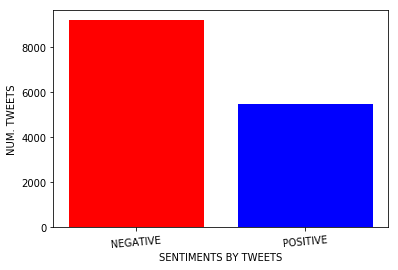

In [5]:
Index=[1, 2]
print(target.value_counts())
plt.bar(Index, target.value_counts(),color=['r','b'])
plt.xticks(Index, ['NEGATIVE', 'POSITIVE'], rotation = 5)
plt.ylabel('NUM. TWEETS')
plt.xlabel('SENTIMENTS BY TWEETS')

In [6]:
Tweets_df_gr=data.groupby(["airline",target]).size().unstack()
print(Tweets_df_gr)

airline_sentiment  negative  positive
airline                              
American               1960       799
Delta                   955      1267
Southwest              1186      1234
US Airways             2263       650
United                 2633      1189
Virgin America          181       323


In [7]:
Tweets_df_gr=data.groupby(["airline",target]).size().unstack()
Tweets_df_gr=Tweets_df_gr.div(Tweets_df_gr.sum(axis=1),axis='index')
print(Tweets_df_gr)

airline_sentiment  negative  positive
airline                              
American           0.710402  0.289598
Delta              0.429793  0.570207
Southwest          0.490083  0.509917
US Airways         0.776862  0.223138
United             0.688906  0.311094
Virgin America     0.359127  0.640873


airline_sentiment  negative  positive
airline                              
American           0.710402  0.289598
Delta              0.429793  0.570207
Southwest          0.490083  0.509917
US Airways         0.776862  0.223138
United             0.688906  0.311094
Virgin America     0.359127  0.640873


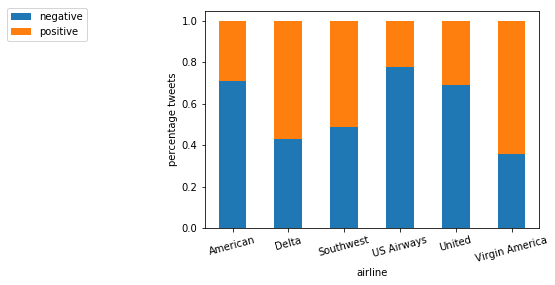

In [8]:
Tweets_df_gr=data.groupby(["airline",target]).size().unstack()
Tweets_df_gr=Tweets_df_gr.div(Tweets_df_gr.sum(axis=1),axis='index')
print(Tweets_df_gr)
ax=Tweets_df_gr.plot.bar(stacked=True)
plt.ylabel('percentage tweets')
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(-0.5, 1), loc=3, borderaxespad=-3)

In [9]:
# It is pre-processed -the mentions, hashtags and links are deleted- each of the tweets saved in 
# the variable 'tweets' with tweet-preprocessor 5.0.
# The tweets are saved in a list ('tweets_preprocessed'), which contains all the tweets without hashtags,
# mentions or links.

tweets_preprocessed = []
for tweet in tweets:
    p.set_options(p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.URL)
    tweets_preprocessed.append(p.clean(tweet))
    

In [10]:
# The list containing each of the pre-processed tweets -the mentions, hashtags and links- is printed to 
# verify that the previous process has been performed correctly.

tweets_preprocessed

['What said.',
 "plus you've added commercials to the experience... tacky.",
 "I didn't today... Must mean I need to take another trip!",
 'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA",
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 'Really missed a prime opportunity for Men Without Hats parody, there.',
 "Well, I didn't…but NOW I DO! :-D",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 'I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "This is such a great deal! Already thinking about my 2nd trip to &amp; I haven't even gone on my 1st trip yet! ;p",
 "I'm flying your skies again! U take all the aw

In [11]:
# A list ('tweets_cleaned_0') is created containing each tweet with the emojis preprocessed. 
# That is, each emoji is replaced and represented with a linguistic expression (token).
tweets_cleaned_0= []  

for tweet in tweets_preprocessed:   
    tweet = emoji.demojize(tweet).replace('_','')
    tweet = re.sub(r'\b\w{1,1}\b', '', tweet)
    tweets_cleaned_0.append(tweet) 

In [12]:
# The list containing each of the pre-processed tweets -the mentions, hashtags, links, emojis- 
# is printed to verify that the previous process has been performed correctly.

tweets_cleaned_0

['What said.',
 "plus you've added commercials to the experience... tacky.",
 " didn' today... Must mean  need to take another trip!",
 'it\' really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it'  really big bad thing about it",
 "seriously would pay $30  flight for seats that didn' have this playing. it' really the only bad thing about flying VA",
 'yes, nearly every time  fly VX this “ear worm” won’ go away :)',
 'Really missed  prime opportunity for Men Without Hats parody, there.',
 "Well,  didn'…but NOW  DO! :-",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 ' &lt; pretty graphics. so much better than minimal iconography. :',
 "This is such  great deal! Already thinking about my 2nd trip to &amp;  haven' even gone on my 1st trip yet! ;",
 "' flying your skies again!  take all the away from travel",
 'Thanks!

In [13]:
# Penultimate stage of preprocessing tweets: treatment of contractions, most common emoticons, digits, capital letters,
# double space, token constituted by only one character, punctuation marks, etc.
# The preprocessed tweets are saved in the 'tweets_cleaned_1' list.

tweets_cleaned_1=[]
for s in range(len(tweets_cleaned_0)):
    tweet = re.sub(r"that's","that is", str(tweets_cleaned_0[s]))
    tweet = re.sub(r"there's","there is",tweet)
    tweet = re.sub(r"you've","you have",tweet)
    tweet = re.sub(r"I've","I have",tweet)
    tweet = re.sub(r"they've","they have",tweet)
    tweet = re.sub(r"we've","we have",tweet)
    tweet = re.sub(r"there're","there are",tweet)
    tweet = re.sub(r"what's","what is",tweet)
    tweet = re.sub(r"what've", "what have", tweet)
    tweet = re.sub(r"where's","where is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"who's","who is",tweet)
    tweet = re.sub(r"i'm","i am",tweet)
    tweet = re.sub(r"they're","they are",tweet)
    tweet = re.sub(r"she's","she is",tweet)
    tweet = re.sub(r"he's","he is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"there're","there are",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    tweet = re.sub(r"ain't","am not",tweet)
    tweet = re.sub(r"wouldn't","would not",tweet)
    tweet = re.sub(r"shouldn't","should not",tweet)
    tweet = re.sub(r"can't","can not",tweet)
    tweet = re.sub(r"couldn't","could not",tweet)
    tweet = re.sub(r"we'll","we will",tweet)
    tweet = re.sub(r"I'll","I will",tweet)
    tweet = re.sub(r"you'll","you will",tweet)
    tweet = re.sub(r"she'll","she will",tweet)
    tweet = re.sub(r"he'll","he will",tweet)
    tweet = re.sub(r"it'll","it will",tweet)
    tweet = re.sub(r"won't","will not",tweet)
    tweet = re.sub(r"could've","could have",tweet)
    tweet = re.sub(r"couldn't've","could not have",tweet)
    tweet = re.sub(r"didn't","did not",tweet)
    tweet = re.sub(r"don't","do not",tweet)
    tweet = re.sub(r"doesn't","does not",tweet)
    tweet = re.sub(r"everyone's","everyone is",tweet)
    tweet = re.sub(r"giv’n","given",tweet)
    tweet = re.sub(r"hasn't","has not",tweet)
    tweet = re.sub(r"haven't","have not",tweet)
    tweet = re.sub(r"hadn't","had not",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"mustn't", "must not", tweet)
    tweet = re.sub(r":D", "smiley", tweet)
    tweet = re.sub(r":-D", "smiley", tweet)
    tweet = re.sub(r":\)", "simple_smile", tweet)
    tweet = re.sub(r";D", "wink", tweet)
    tweet = re.sub(r";D", "wink", tweet)
    tweet = re.sub(r":-\)", "simple_smile", tweet)
    tweet = re.sub(r";\)", "wink", tweet)
    tweet = re.sub(r";-\)", "wink", tweet)
    tweet = re.sub(r":P", "stuck_out_tongue", tweet)
    tweet = re.sub(r":-P", "stuck_out_tongue", tweet)
    tweet = re.sub(r";P", "stuck_out_tongue_closed_eyes", tweet)
    tweet = re.sub(r";-P", "stuck_out_tongue_closed_eyes", tweet)
    tweet = re.sub(r":\(", "worried", tweet)
    tweet = re.sub(r":-\(", "worried", tweet)
    tweet = re.sub(r":'\('", "cry", tweet)
    tweet = re.sub(r'\W', ' ', tweet)  
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'^br$', ' ', tweet)
    tweet = re.sub(r'^[a-zA-Z]\s', ' ', tweet)
    tweet = re.sub(r'\s+br\s+',' ',tweet)
    tweet = re.sub(r'\s+[a-z]\s+', ' ',tweet)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.split()
    tweet = ' '.join(tweet)
    tweets_cleaned_1.append(tweet) 

In [14]:
# The list containing each of the pre-processed tweets is printed to verify that the previous process
# has been performed correctly.

tweets_cleaned_1

['what said',
 'plus you have added commercials to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va',
 'yes nearly every time fly vx this ear worm won go away simple_smile',
 'really missed prime opportunity for men without hats parody there',
 'well didn but now do',
 'it was amazing and arrived an hour early you re too good to me',
 'did you know that suicide is the second leading cause of death among teens',
 'lt pretty graphics so much better than minimal iconography',
 'this is such great deal already thinking about my nd trip to amp haven even gone on my st trip yet',
 'flying your skies again take all the away from travel',
 'thanks',
 'sfo pdx schedule is still mia',
 'so excited for my first cro

In [15]:
# The 'tweets_cleaned_0' list is printed to make it easier to compare the text of the tweets
# in the last two stages of text preprocessing.

tweets_cleaned_0

['What said.',
 "plus you've added commercials to the experience... tacky.",
 " didn' today... Must mean  need to take another trip!",
 'it\' really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it'  really big bad thing about it",
 "seriously would pay $30  flight for seats that didn' have this playing. it' really the only bad thing about flying VA",
 'yes, nearly every time  fly VX this “ear worm” won’ go away :)',
 'Really missed  prime opportunity for Men Without Hats parody, there.',
 "Well,  didn'…but NOW  DO! :-",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 ' &lt; pretty graphics. so much better than minimal iconography. :',
 "This is such  great deal! Already thinking about my 2nd trip to &amp;  haven' even gone on my 1st trip yet! ;",
 "' flying your skies again!  take all the away from travel",
 'Thanks!

In [16]:
# Last stage of preprocessing tweets: each of the tweets' token is lemmatized
# Lemmatization --> the process of grouping together the different inflected forms of a word so
# they can be analysed as a single item.

tweets_cleaned_2=[]

for sentence in tweets_cleaned_1:
    lem = lemmatize_sentence(sentence)
    lem = ' '.join(lem)
    tweets_cleaned_2.append(lem)

In [17]:
# The list containing each of the pre-processed tweets is printed to verify that 
# the previous process has been performed correctly.

tweets_cleaned_2

['what say',
 'plus you have add commercial to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guest face amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seat that didn have this playing it really the only bad thing about fly va',
 'yes nearly every time fly vx this ear worm win go away simple_smile',
 'really missed prime opportunity for men without hat parody there',
 'well didn but now do',
 'it be amaze and arrive an hour early you re too good to me',
 'do you know that suicide be the second leading cause of death among teen',
 'lt pretty graphic so much good than minimal iconography',
 'this be such great deal already think about my nd trip to amp haven even go on my st trip yet',
 'fly your sky again take all the away from travel',
 'thanks',
 'sfo pdx schedule be still mia',
 'so excited for my first cross country flight lax to mco v

In [18]:
# The 'tweets_cleaned_1' list is printed to make it easier to compare the text of the tweets in the last
# two stages of text preprocessing.

tweets_cleaned_1

['what said',
 'plus you have added commercials to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va',
 'yes nearly every time fly vx this ear worm won go away simple_smile',
 'really missed prime opportunity for men without hats parody there',
 'well didn but now do',
 'it was amazing and arrived an hour early you re too good to me',
 'did you know that suicide is the second leading cause of death among teens',
 'lt pretty graphics so much better than minimal iconography',
 'this is such great deal already thinking about my nd trip to amp haven even gone on my st trip yet',
 'flying your skies again take all the away from travel',
 'thanks',
 'sfo pdx schedule is still mia',
 'so excited for my first cro

In [19]:
# The 'target_tweet' Data Frame is created. It contains the text of each of the tweets in the 'tweet'
# column and its respective polarity (positive or negative).
# This process is used to verify that the previous processes have been executed correctly. 
# Each tweet contains its respective tag -> polarity.

data_target_tweet = {'target': target, 'tweet': tweets_cleaned_2}
target_tweet = pd.DataFrame(data=data_target_tweet)
target_tweet

,target,tweet
0,positive,what say
1,positive,plus you have add commercial to the experience...
2,positive,didn today must mean need to take another trip
3,negative,it really aggressive to blast obnoxious entert...
4,negative,and it really big bad thing about it
5,negative,seriously would pay flight for seat that didn ...
6,positive,yes nearly every time fly vx this ear worm win...
7,positive,really missed prime opportunity for men withou...
8,positive,well didn but now do
9,positive,it be amaze and arrive an hour early you re to...


In [20]:
# The BOW (Bag of Words) model is created --> a way of representing text data when modeling text with 
# machine learning algorithms. Any information about the order or structure of words in the document
# is discarded. The model is only concerned with whether known words occur in the document, not where in the document.
# CountVectorizer --> convert a collection of text documents to a matrix of token counts --> X.

vectorizer = CountVectorizer(max_features=6000, min_df=1, max_df=0.9, stop_words=stopwords.words('english'))  
X = vectorizer.fit_transform(tweets_cleaned_2).toarray()  

In [21]:
# The TF-IDF model is created --> transform a count matrix (X) to a normalized tf-idf representation (X). 
# Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency.

tfidfconverter = TfidfTransformer()  
X = tfidfconverter.fit_transform(X).toarray() 
y= target

In [22]:
# The data is divided into a training set (80%) and a test set (20%).

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size= 0.2, random_state=0)

In [23]:
# The Random Forest classifier is applied to train with the data from the training set. 
# Subsequently, its degree of accuracy is checked by predicting the labels of the test set
# Training the classifier.

classifier = RandomForestClassifier(n_estimators=2000, random_state=0)  
classifier.fit(X_train, y_train) 
# Testing model performance
y_pred=classifier.predict(X_test)

In [24]:
# The results of the Random Forest classifier are printed to proceed with its evaluation
# Random Forest Classifier.

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[1679  191]
 [ 361  697]]
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1870
    positive       0.78      0.66      0.72      1058

   micro avg       0.81      0.81      0.81      2928
   macro avg       0.80      0.78      0.79      2928
weighted avg       0.81      0.81      0.81      2928

0.8114754098360656


Confusion Matrix (no-normalized)
[[1679  191]
 [ 361  697]]
Confusion Matrix (normalized)
[[0.89786096 0.10213904]
 [0.34120983 0.65879017]]


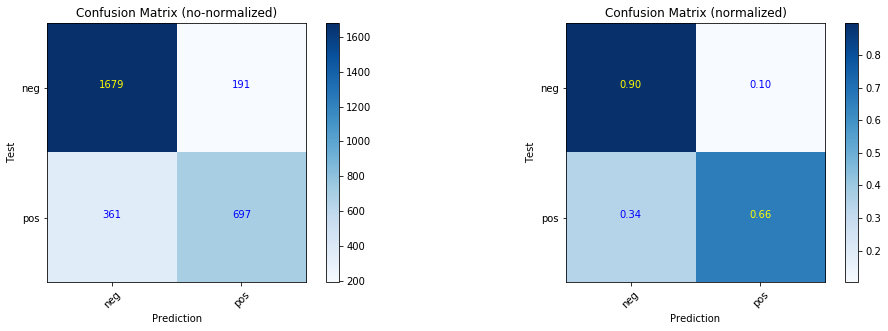

In [25]:
# The graphic representation of the results of the Random Forest classifier is created.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix (normalized)")
    else:
        print('Confusion Matrix (no-normalized)')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="yellow" if cm[i, j] > thresh else "blue")

    plt.ylabel('Test')
    plt.xlabel('Prediction')
    plt.tight_layout()


# Compute confusion matrix.

cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot 
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()

In [26]:
# The Logistic Regression classifier is applied to train with the data from the training set. Subsequently, its degree of accuracy is checked by predicting the labels of the test set
# Training the classifier 
classifier = LogisticRegression()  
classifier.fit(X_train, y_train) 
# Testing model performance
y_pred=classifier.predict(X_test)

/home/dsc/anaconda3/envs/Kschool/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# The results of the Logistic Regression classifier are printed to proceed with its evaluation.
# Logistic Regression Classifier.

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[1684  186]
 [ 339  719]]
              precision    recall  f1-score   support

    negative       0.83      0.90      0.87      1870
    positive       0.79      0.68      0.73      1058

   micro avg       0.82      0.82      0.82      2928
   macro avg       0.81      0.79      0.80      2928
weighted avg       0.82      0.82      0.82      2928

0.8206967213114754


Confusion Matrix (no-normalized)
[[1684  186]
 [ 339  719]]
Confusion Matrix (normalized)
[[0.90053476 0.09946524]
 [0.32041588 0.67958412]]


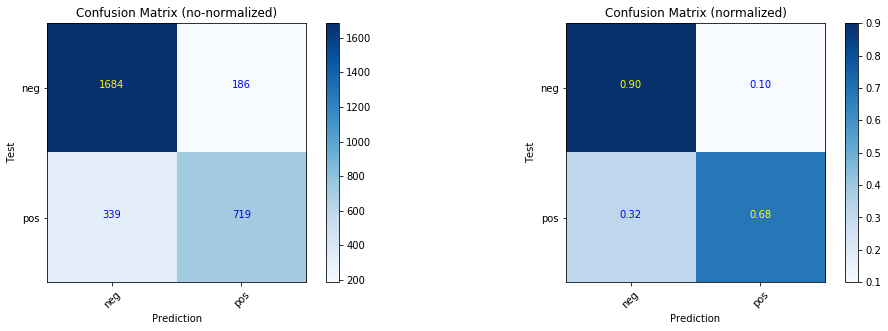

In [28]:
# The graphic representation of the results of the Random Forest classifier is created.
# Plot --> Confusion Matrix: Logistic Regression.

cnf_matrix_lr = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg',  'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()

In [29]:
# The SVM (Support Vector Machine) classifier is applied to train with the data from the training set. 
# Subsequently, its degree of accuracy is checked by predicting the labels of the test set.
# Training the classifier.

classifier = svm.SVC(kernel='linear')  
classifier.fit(X_train, y_train) 
# Testing model performance
y_pred=classifier.predict(X_test)

In [30]:
# The results of the SVM classifier are printed to proceed with its evaluation
# SVM Classifier.

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[1645  225]
 [ 315  743]]
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1870
    positive       0.77      0.70      0.73      1058

   micro avg       0.82      0.82      0.82      2928
   macro avg       0.80      0.79      0.80      2928
weighted avg       0.81      0.82      0.81      2928

0.8155737704918032


Confusion Matrix (no-normalized)
[[1645  225]
 [ 315  743]]
Confusion Matrix (normalized)
[[0.87967914 0.12032086]
 [0.29773157 0.70226843]]


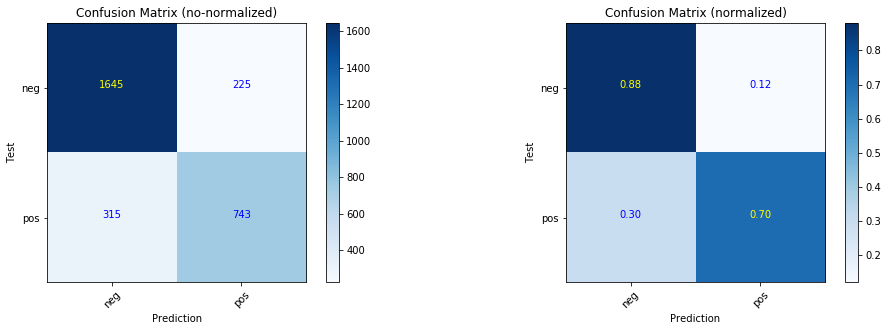

In [31]:
# The graphic representation of the results of the SVM classifier is created
# Plot --> Confusion Matrix: SVM

cnf_matrix_lr = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg',  'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()

In [32]:
# The Decision Tree classifier is applied to train with the data from the training set. 
# Subsequently, its degree of accuracy is checked by predicting the labels of the test set
# Training the classifier.

classifier = tree.DecisionTreeClassifier()  
classifier.fit(X_train, y_train) 
# Testing model performance
y_pred=classifier.predict(X_test)

In [33]:
# The results of the Decision Tree classifier are printed to proceed with its evaluation
# Decision Tree Classifier.

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[1518  352]
 [ 364  694]]
              precision    recall  f1-score   support

    negative       0.81      0.81      0.81      1870
    positive       0.66      0.66      0.66      1058

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.74      0.73      0.73      2928
weighted avg       0.75      0.76      0.76      2928

0.755464480874317


Confusion Matrix (no-normalized)
[[1518  352]
 [ 364  694]]
Confusion Matrix (normalized)
[[0.81176471 0.18823529]
 [0.34404537 0.65595463]]


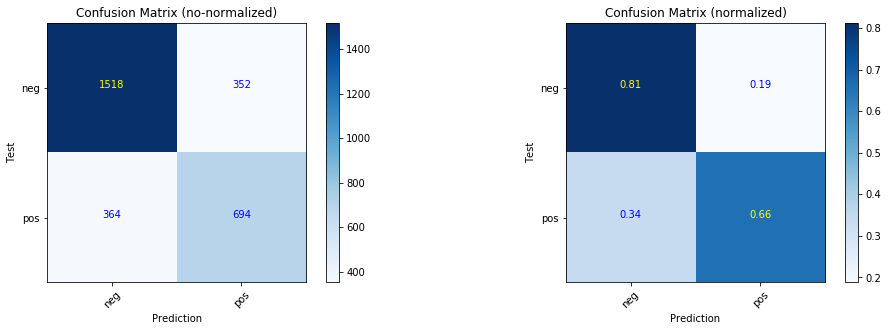

In [34]:
# The graphic representation of the results of the Decision Tree classifier is created
# Plot --> Confusion Matrix: Decision Tree.

cnf_matrix_lr = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg',  'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()